In [7]:
import os
import matplotlib.pyplot as plt
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import MNIST

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint


if not os.path.exists("data/MNIST"):
    MNIST("data", train=True, download=True)
    MNIST("data", train=False, download=True)

batch_size = 256
num_workers = 8
transform = transforms.Compose([
    transforms.ToTensor()
])
    
mnist_full = MNIST("data", train=True, transform=transform)
train_data, valid_data = random_split(mnist_full, [55000, 5000])
test_data = MNIST("data", train=False, transform=transform)

train_dataloader = DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
valid_dataloader = DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers)
test_dataloader = DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

In [2]:
# https://esther-eun27.tistory.com/4
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.block2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        
    def forward(self, x):
        for layer in [self.block1, self.block2]:
            x = layer(x)
            
        return x

        
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.block1 = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2, padding=0),
            nn.ReLU()
        )
        
        self.block2 = nn.Sequential(
            nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2, padding=0)
        )
       
    
    def forward(self, x):
        for layer in [self.block1, self.block2]:
            x = layer(x) 
            
        x = F.sigmoid(x)
        
        return x

    
class AutoEncoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        
        return x


In [3]:
class AE(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    
    def forward(self, x):
        return self.model(x)
    
    
    def training_step(self, batch, batch_idx):
        imgs, _ = batch
        
        recon_imgs = self(imgs)
        loss = F.mse_loss(recon_imgs, imgs)

        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        
        return loss
    
    
    def validation_step(self, batch, batch_idx):
        imgs, _ = batch
        
        recon_imgs = self(imgs)
        loss = F.mse_loss(recon_imgs, imgs)
        
        self.log('valid_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=0.0002, betas=(0.9, 0.999))
        
        return optimizer


callbacks = [
    ModelCheckpoint(monitor='valid_loss', save_top_k=5, dirpath='weights/DCAE', filename='ConvolutionalAE-{epoch:03d}-{valid_loss:.4f}'),
]


encoder = Encoder()
decoder = Decoder()

model = AutoEncoder(encoder=encoder, decoder=decoder)
auto_encoder = AE(model)
trainer = pl.Trainer(gpus=1, max_epochs=30, enable_progress_bar=True, callbacks=callbacks)

/home/ubuntu/anaconda3/envs/pytorch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:429: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [4]:
# trainer.fit(auto_encoder, train_dataloader, valid_dataloader)

In [5]:
import random

idx = list(range(len(test_data.data)))
random.shuffle(idx)
idx = idx[:16]
test_samples = test_data.data[idx].unsqueeze(1).float()

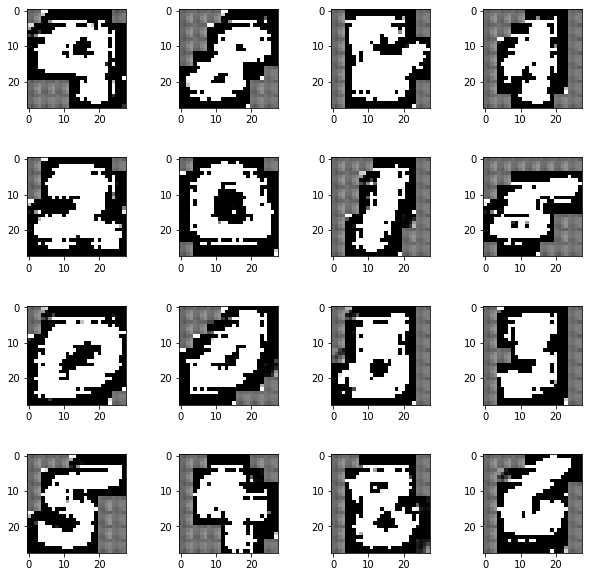

In [8]:
ckpt_fname = "ConvolutionalAE-epoch=029-valid_loss=0.8531.ckpt"
auto_encoder = auto_encoder.load_from_checkpoint("weights/DCAE/" + ckpt_fname, model=model)

samples = auto_encoder(test_samples).view(-1, 1, 28, 28)
samples = samples.detach().moveaxis(1, -1).to("cpu").numpy()

plt.figure(figsize=(10, 10))
plt.subplots_adjust(hspace=0.5, wspace=0.5)
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(samples[i, :], cmap="gray")

plt.show()